In [1]:
from AllenDriftClasses import *

In [66]:
import matplotlib
font = {'family' : 'normal',
    'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
from AllenDriftClasses import *

'''In this part we call the saved dff traces of experiments in different brain regions and different mice from file (Data)'''
mouses = {}
for area in BOC.get_all_targeted_structures():
    mouses[area] = Analyzer.get_mice(areas=[area])


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


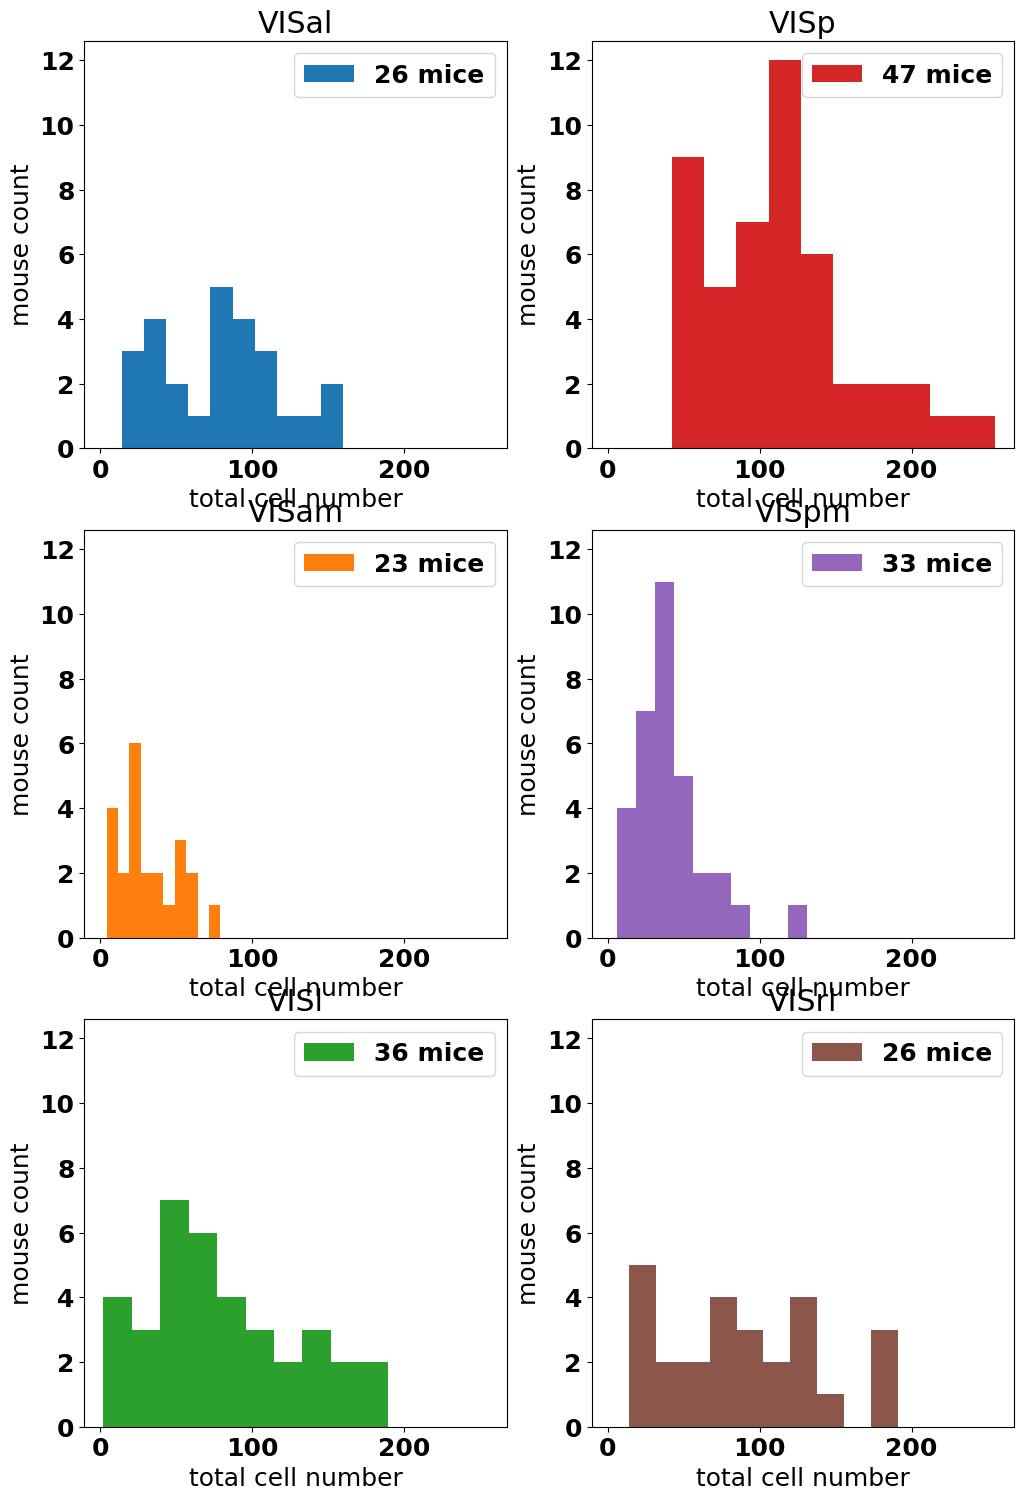

In [67]:
''''This script plot the diversity of cell counts across different regions''' 

areas = BOC.get_all_targeted_structures()
# fig = plt.figure(figsize=(5, 15))
import matplotlib.colors as mcolors

cellsnumber = {area : [] for area in areas}

for area in areas:
    for mouse in mouses[area]:
        cellsnumber[area].append(mouse.dff.shape[0])



fig, axes = plt.subplots(nrows=3, ncols=2, sharex = 'all', sharey='all')
fig.set_size_inches(2*6, 3*6)


for i, area in enumerate(areas):
    row = np.mod(i, 3)
    col = int(i/3)
    ax = axes[row, col]

    ax.hist(cellsnumber[area], color = list(mcolors.TABLEAU_COLORS.values())[i],density=False, label = str(len(cellsnumber[area])) + ' mice' )
    ax.set_title(area)
    ax.tick_params(labelbottom=True, labelleft=True)
    ax.set_ylabel('mouse count')
    ax.set_xlabel("total cell number")
    ax.legend()



plt.show()

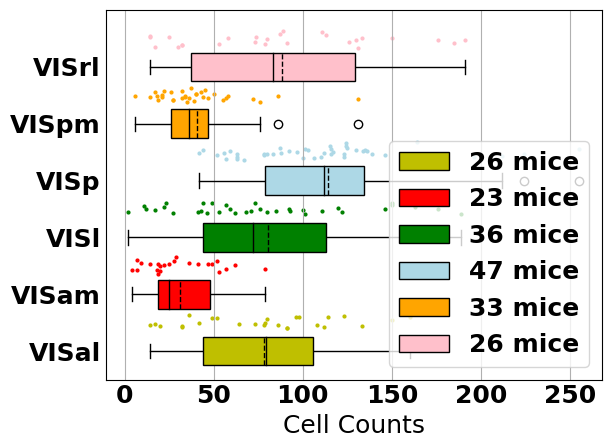

In [68]:
# for i, area in enumerate(areas):
x = [cellsnumber[area] for area in areas]
labels = [str(len(x[i])) + ' mice' for i in range(6)]

import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())[0:6]
colors = ['y', 'r', 'g', 'lightblue', 'orange', 'pink']

bp = plt.boxplot(x, positions= np.arange(6), notch=False, vert=False, patch_artist=True, meanline=True, showmeans=True)

plt.setp(bp['medians'], color='k')

for i in range(6):
    plt.setp(bp['means'][i], color = 'k')
    plt.setp(bp["boxes"][i], facecolor=colors[i])
    plt.scatter(x[i] , np.ones(len(x[i]))*i +0.5+0.07*np.random.randn(len(x[i])), color=colors[i], marker='o', s = 4)
    

plt.yticks(np.arange(6), areas)
plt.tick_params(length = 0,labeltop = False, labelbottom=True)
plt.xlabel('Cell Counts')
plt.ylim([-0.5, 6])

# plt.title('Boxplot of cell counts in different mice and brain areas\n')
plt.legend(bp['boxes'], labels, loc='lower right')
# plt.gca().xaxis.set_label_position('top')
plt.grid(axis='x')
plt.savefig('OtherPlots/cell_counts.pdf')

plt.show()


In [39]:
from sklearn.decomposition import PCA

pca_save = {area : [] for area in areas}

for area in areas:
    print('      ', end='\r')
    print(area)
    for index, mouse in enumerate(mouses[area]):
        print(str(np.round(100*index/len(mouses[area]), 1)) + '%', end='\r')
        model = PCA()
        dff = mouse.dff
        dff = dff.reshape([dff.shape[0], 27000]).T
        model.fit(dff)
        pca_save[area].append(model)

VISal 
VISam 
VISl  
VISp  
VISpm 
VISrl 


In [40]:
N_threshold = 25

# Doing a cutoff on the experiment with number of cells smaller than a threshold
new_pca_save = {area : [] for area in areas}
for area in areas:
    for mouse_index in range(len(pca_save[area])):
        # print(mouse_index, pca_save[area][mouse_index].n_features_)
        if pca_save[area][mouse_index].n_features_ > N_threshold:
            new_pca_save[area].append(pca_save[area][mouse_index])
            

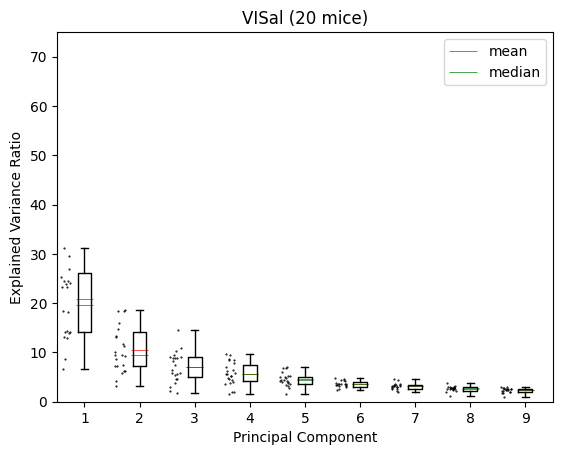

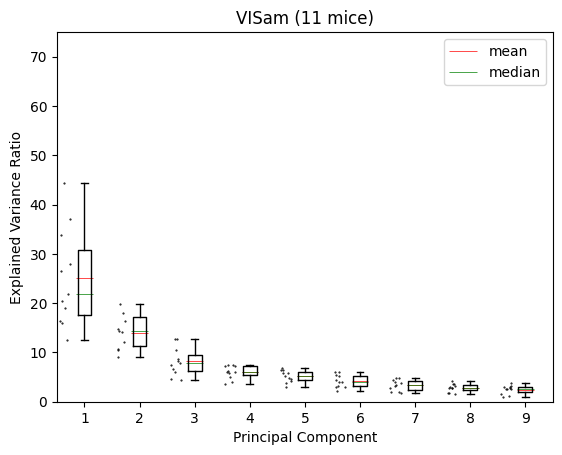

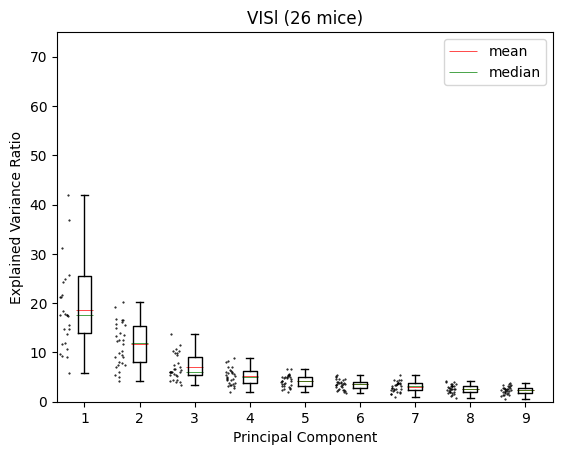

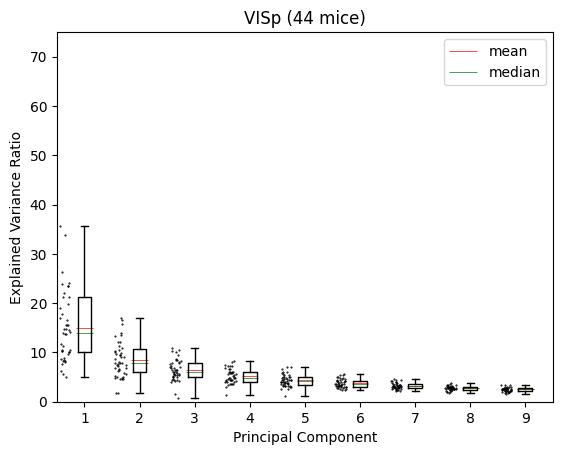

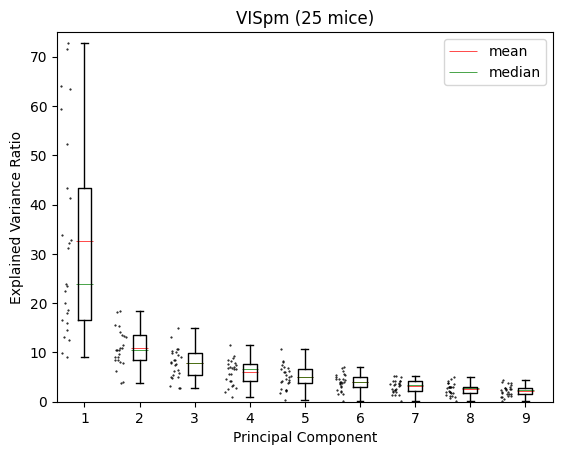

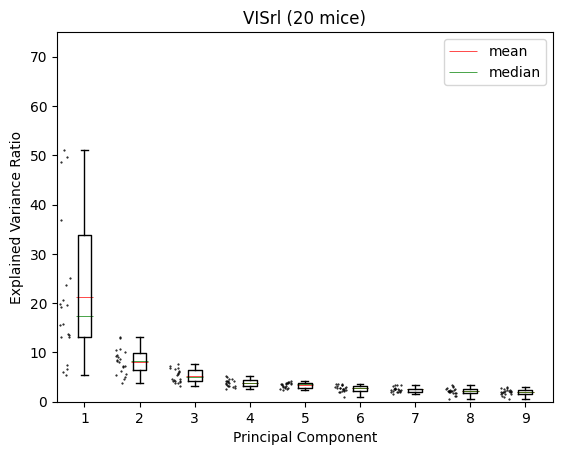

In [41]:
# Function to remove outliers from data
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
 
    return [x for x in data if (x >= lower_bound) and (x <= upper_bound)]




n = 50 # number of components to analyze
save_for_mean = {area: [[] for i in range(n)] for area in areas}
for area_index, area in enumerate(areas):
    
    explained_variance = [[]for i in range(n)]
    for index, pca in enumerate(new_pca_save[area]):
        
        for j in range(min(len(pca.explained_variance_ratio_), n)):
            explained_variance[j].append(100*pca.explained_variance_ratio_[j])
        
        
        # import matplotlib.colors as mcolors
        # colors = list(mcolors.XKCD_COLORS.values())[:len(explained_variance[0])]

        # data = pca.explained_variance_ratio_
        # data_size = min(len(data), n)
        # plt.plot(2*np.arange(data_size) -0.7 + 0.4*(np.random.rand(data_size)-0.5), data[:data_size], markersize = 2, marker='.', linestyle='')
    
    bp = plt.boxplot(explained_variance, positions=2*np.arange(n), sym = '', showfliers= False, meanline=False ,showmeans=False, medianprops=dict(linewidth=0))

    # fliers = bp['fliers'][0].get_data()[1]
    number_of_mice = 0
    for i in range(n):
        data = remove_outliers(explained_variance[i])
        data_size = len(data)
        save_for_mean[area][i] = list(data)
        if i == 0:
            number_of_mice = data_size
        plt.plot(2*i-0.7 + 0.4*(np.random.rand(data_size)-0.5), data, markersize = 1, marker='.', linestyle='', color='k')
        
        labels = ['mean', 'median']
        if i != 0:
            labels = [None, None]
        plt.hlines(y=np.mean(data), xmin = 2*i-0.3, xmax=2*i+0.3, color='r', linewidth = 0.5, label=labels[0])
        plt.hlines(y=np.median(data), xmin = 2*i-0.3, xmax=2*i+0.3, color='g', linewidth = 0.5, label=labels[1])
    
    
    plt.legend()
    plt.xlabel('Principal Component')
    
    plt.xticks(2*np.arange(n), np.arange(n)+1)
    plt.xlim([-1, 17])
    plt.ylabel('Explained Variance Ratio')
    plt.title(area + ' (' + str(number_of_mice) + ' mice)')
    plt.ylim([0, 75])
    # plt.grid(axis = 'y')
    plt.savefig('PCA_Variance_ratio_boxplot/pca_' + area + '_boxplot.pdf')
    plt.show()

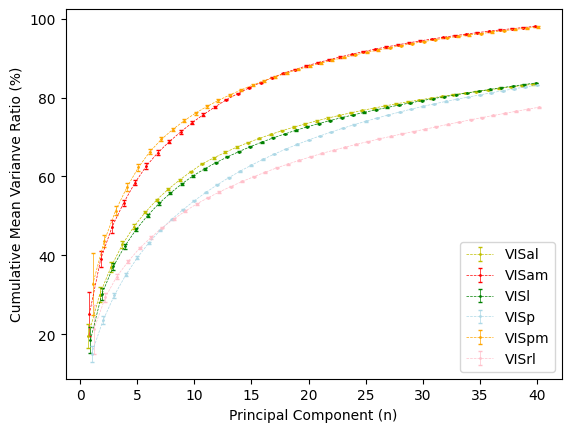

In [42]:
n = 40
mean_error = {area: [] for area in areas}
for area in areas: 
    for i in range(n):
        temp = np.array(save_for_mean[area][i])
        mean_error[area].append([temp.mean(), temp.std()/np.sqrt(len(temp))])

mean_error = {area: np.array(mean_error[area]) for area in areas}

for index, area in enumerate(areas):
    error =  1.96*mean_error[area][:, 1]
    means =  mean_error[area][:, 0]

    x = np.arange(n) + 1
    y = means

    plt.errorbar(x + 0.1*(index-3), np.cumsum(y), yerr = error, color = colors[index], label=area, markersize=2, marker='.', linestyle ='--', linewidth=0.5, capsize=1.5)

    plt.xlabel('Principal Component (n)')
    plt.ylabel('Cumulative Mean Varianve Ratio (%)')
    # plt.title('Averaged across mice variance ratio Vs. PC component')

  
    yticks = [str(np.arange(0, 45, 5)[i]) for i in range(9)]

plt.legend()
plt.savefig('OtherPlots/cumsum_Variance_ratio.pdf')

plt.show()

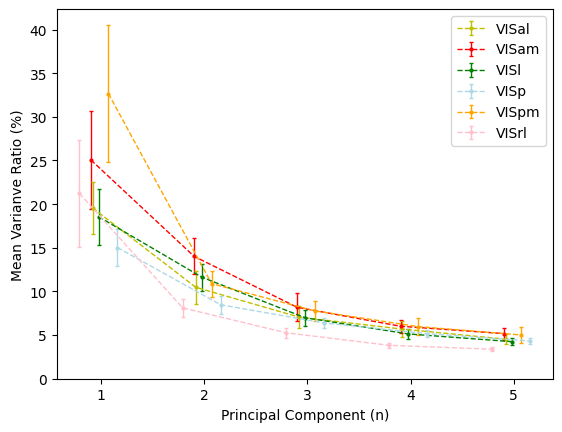

In [43]:
n = 5

mean_error = {area: [] for area in areas}
for area in areas: 
    for i in range(n):
        temp = np.array(save_for_mean[area][i])
        mean_error[area].append([temp.mean(), temp.std()/np.sqrt(len(temp))])

mean_error = {area: np.array(mean_error[area]) for area in areas}

for index, area in enumerate(areas):
    error =  1.96*mean_error[area][:, 1]
    means =  mean_error[area][:, 0]

    x = np.arange(n) + 1
    y = means

    plt.errorbar(x + 0.1*np.random.randn(), y, color = colors[index], yerr = error, label=area, markersize=4, marker='.', linestyle ='--', linewidth=1, capsize=1.5)

    plt.xlabel('Principal Component (n)')
    plt.ylabel('Mean Varianve Ratio (%)')
    # plt.title('Averaged across mice variance ratio Vs. PC component')
  
    yticks = [str(np.arange(0, 45, 5)[i]) for i in range(9)]
    plt.yticks(np.arange(0, 45, 5), yticks)

plt.legend()
plt.savefig('OtherPlots/Variance_ratio.pdf')

plt.show()

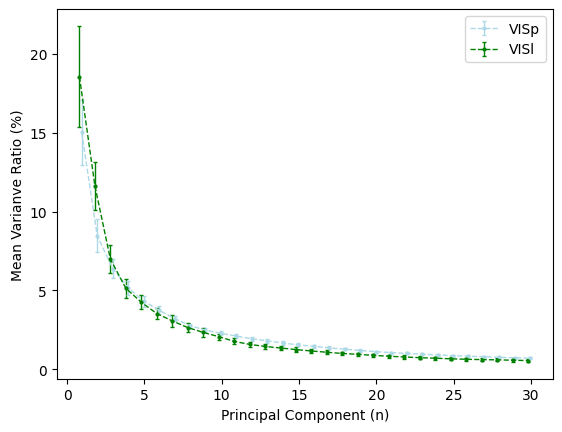

In [44]:
n = 30

mean_error = {area: [] for area in areas}
for area in areas: 
    for i in range(n):
        temp = np.array(save_for_mean[area][i])
        mean_error[area].append([temp.mean(), temp.std()/np.sqrt(len(temp))])

mean_error = {area: np.array(mean_error[area]) for area in areas}

for index, area in enumerate(['VISp', 'VISl']):
    error =  1.96*mean_error[area][:, 1]
    means =  mean_error[area][:, 0]

    x = np.arange(n) + 1
    y = means
    
    plt.errorbar(x + 0.1*np.random.randn(), y, color = colors[areas.index(area)], yerr = error, label=area, markersize=4, marker='.', linestyle ='--', linewidth=1, capsize=1.5)

    plt.xlabel('Principal Component (n)')
    plt.ylabel('Mean Varianve Ratio (%)')
    # plt.title('Averaged across mice variance ratio Vs. PC component')
  
    # yticks = [str(np.arange(0, 45, 5)[i]) for i in range(9)]
    # plt.yticks(np.arange(0, 45, 5), yticks)

plt.legend()
plt.savefig('OtherPlots/V1_Vlm.pdf')

plt.show()

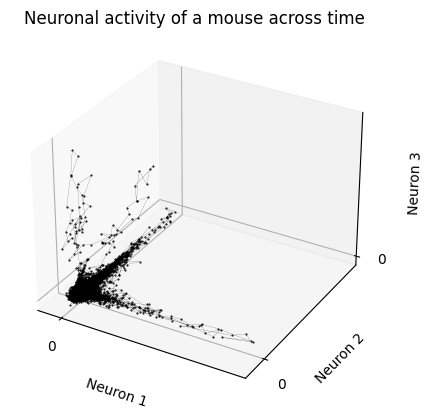

In [45]:
fig = plt.figure()
ax = plt.axes(projection='3d')
data = mouses['VISp'][10].dff[0:3].reshape([3, 27000])
ax.plot(data[0,:], data[1,:], data[2,:], marker = 'o', markersize = 0.5, linestyle='-', linewidth=0.1, color = 'k')
ax.set_xlabel('Neuron 1')
ax.set_ylabel('Neuron 2')
ax.set_zlabel('Neuron 3')

ax.set_xticks([0])
ax.set_yticks([0])
ax.set_zticks([0])

# ax.view_init(elev = 25, azim = 10, roll = 0)
# # manual arrowhead width and length
# xmin, xmax = 0, 4.5
# ymin, ymax = 0, 4.5
# hw = 1./20.*(ymax-ymin) 
# hl = 1./20.*(xmax-xmin)
# lw = 1. # axis line width
# ohg = 0.3 # arrow overhang

# # compute matching arrowhead length and width
# yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
# yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

# # draw x and y axis
# ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
#          head_width=hw, head_length=hl, overhang = ohg, 
#          length_includes_head= True, clip_on = False) 

# ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
#          head_width=yhw, head_length=yhl, overhang = ohg, 
#          length_includes_head= True, clip_on = False) 
ax.set_title('Neuronal activity of a mouse across time')
plt.savefig('OtherPlots/Neuronal_activity.pdf')
plt.show()


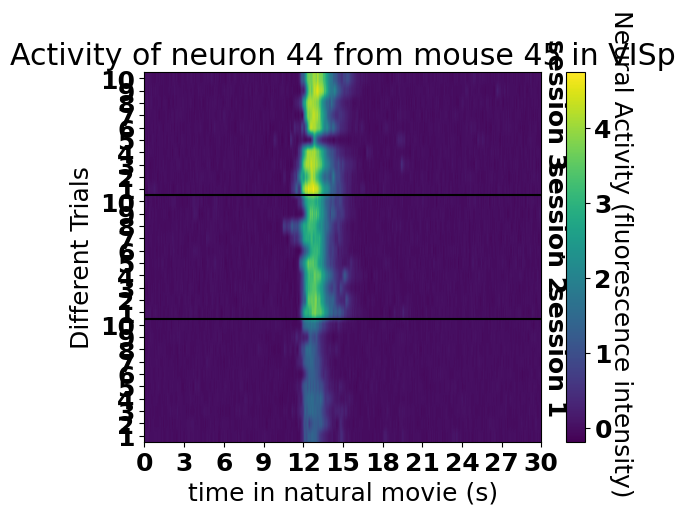

In [69]:

def neuronal_activity_plot(imshow = True, area = None, neuron_index = None, mouse_index = None):
    global mouses, areas 
    
    if area == None:
        area = np.random.choice(areas)
    if mouse_index == None:
        mouse_index = np.random.choice(np.arange(len(mouses[area])))
        neuron_index = np.random.choice(np.arange(mouses[area][mouse_index].dff.shape[0]))
        
    
    DFF = mouses[area][mouse_index].dff
    plt.ioff()
    scale = 1
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    if imshow:
        im = ax.imshow(DFF[neuron_index].reshape([30, 900]), aspect = 'auto')
        cbar = fig.colorbar(im, orientation='vertical')
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel('Neural Activity (fluorescence intensity) \n \n.', rotation=270)
    else :
        for session in range(3):
            for repeat in range(10):
                ax.plot(DFF[neuron_index, session, repeat, :] + scale*(10*session + repeat), color='gray') 
    
    ax.set_xlabel('time in natural movie (s)')
    Number_of_x_ticks = 11
    ax.set_xticks(np.linspace(0, 900, Number_of_x_ticks))
    ax.set_xticklabels(np.linspace(0, 30, Number_of_x_ticks).astype(int))
    
    
    ax.set_ylabel('Different Trials')
    ax.set_yticks(np.arange(0, 30)*scale)
    ax.set_yticklabels(list(range(1, 11))*3)

    ax.hlines(y=scale*(np.array([10, 20]) - 0.5), xmin=0, xmax=900, linestyle = '-', color = 'k')

    ax.set_xlim([0, 900])
    ax.set_ylim((np.array([0, 30])-0.5)*scale)

    for i in range(3):
        ax.text(x=905, y= scale*(i*10 + 2),s= 'session ' + str(i+1), rotation = -90)
    ax.set_title('Activity of neuron ' + str(neuron_index+1) + ' from mouse ' + str(mouse_index+1) + ' in ' + str(area))
       
#     ax.tick_params(axis = 'y', width = 0)
    
    return ax

ax = neuronal_activity_plot(imshow= True, mouse_index=44, neuron_index=43, area = 'VISp')
plt.show()

In [47]:
# area * mouse * neuron * (30, 30)
correlation_data = {area : [] for area in areas}

for area in areas:
    print(area, end='\r')
    for mouse in mouses[area]:
        DFF = mouse.dff
        corr_matrix = np.zeros([DFF.shape[0], 30, 30])
        for neuron in range(DFF.shape[0]):
            corr_matrix[neuron, :, :] = np.corrcoef(DFF[neuron].reshape([30, 900]))
        correlation_data[area].append(corr_matrix)


In [48]:
mean_corr_with_error = {area : [[] for mouse in enumerate(mouses[area])] for area in areas}

for area in areas:
    for mouse_index, mouse in enumerate(mouses[area]):
        for neuron_index in range(mouse.dff.shape[0]):
            matrix = correlation_data[area][mouse_index][neuron_index]
            # selecting the upper triangle of corr coef matrix
            corrs = matrix[np.triu(matrix, k=1) == matrix]
            mean_corr = corrs.mean()
            error_corr = corrs.std(ddof=1)/np.sqrt(len(corrs))
            mean_corr_with_error[area][mouse_index].append([mean_corr, error_corr]) 

In [51]:
# a function that find the active and robust cells with a threshold measure in correlation between signals

def find_sensitive_cells(threshold = 0.8):
    global areas, mean_corr_with_error, mouses
    sensitive_cells = {}

    for area in areas:
        for mouse_index, mouse in enumerate(mouses[area]):
            data = np.array(mean_corr_with_error[area][mouse_index])[:, 0]

            reliable_cells_indices = np.where(data > threshold)[0]
            if len(reliable_cells_indices) > 0:
                sensitive_cells[(area, mouse_index)] = reliable_cells_indices
    return sensitive_cells

# Saving these neurons
for key, value in find_sensitive_cells(threshold=0.8).items():
    for neuron in value:
        ax1 = neuronal_activity_plot(imshow=True,area = key[0], mouse_index=key[1], neuron_index = neuron)
        plt.savefig('Active_Cells_Imshow//'+ key[0] + '_mouse'+ str(key[1]) + '_neuron' + str(neuron) + '.pdf')
        plt.close()
        ax2 = neuronal_activity_plot(imshow=False,area = key[0], mouse_index=key[1], neuron_index = neuron)
        plt.savefig('Active_Cells_signals//'+ key[0] + '_mouse'+ str(key[1]) + '_neuron' + str(neuron) + '.pdf')
        plt.close()

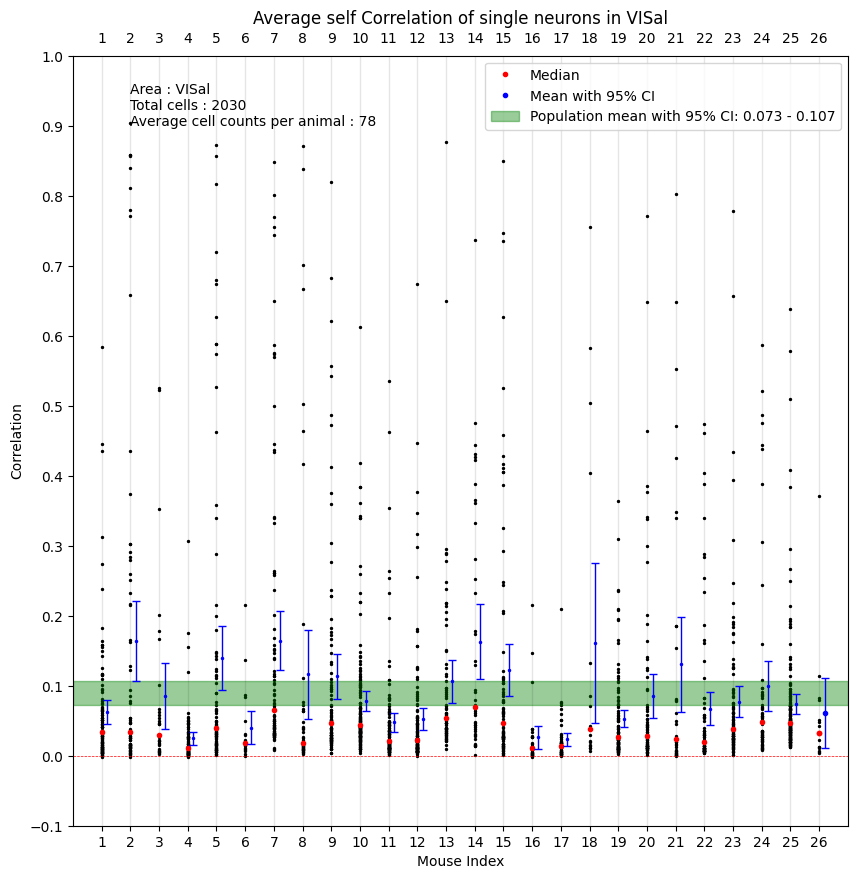

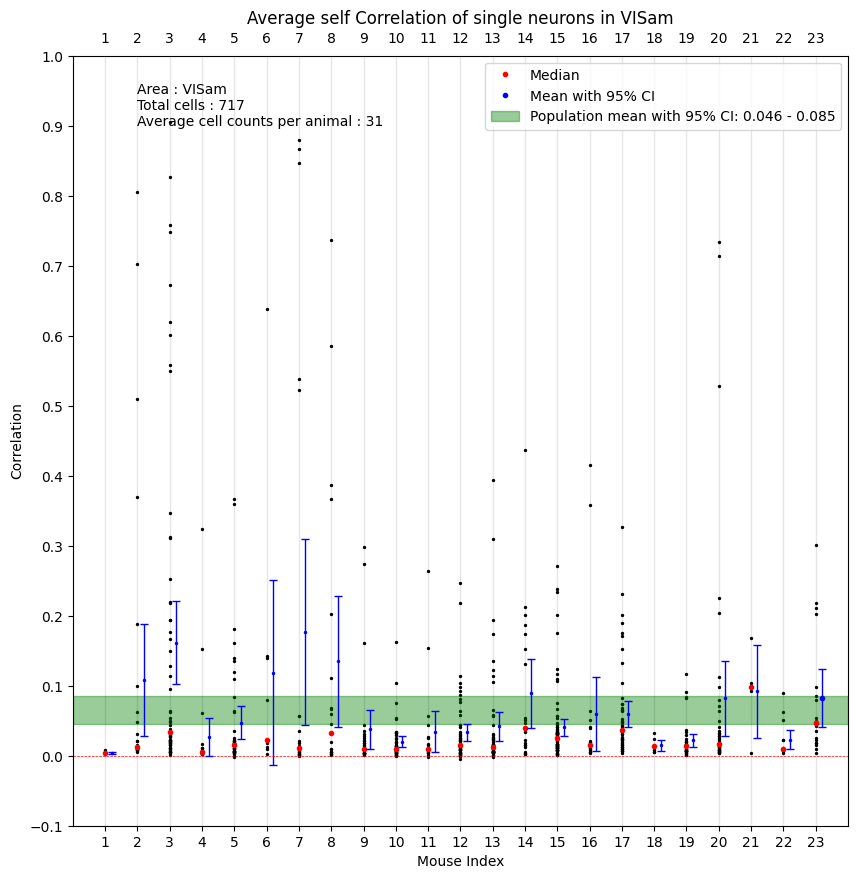

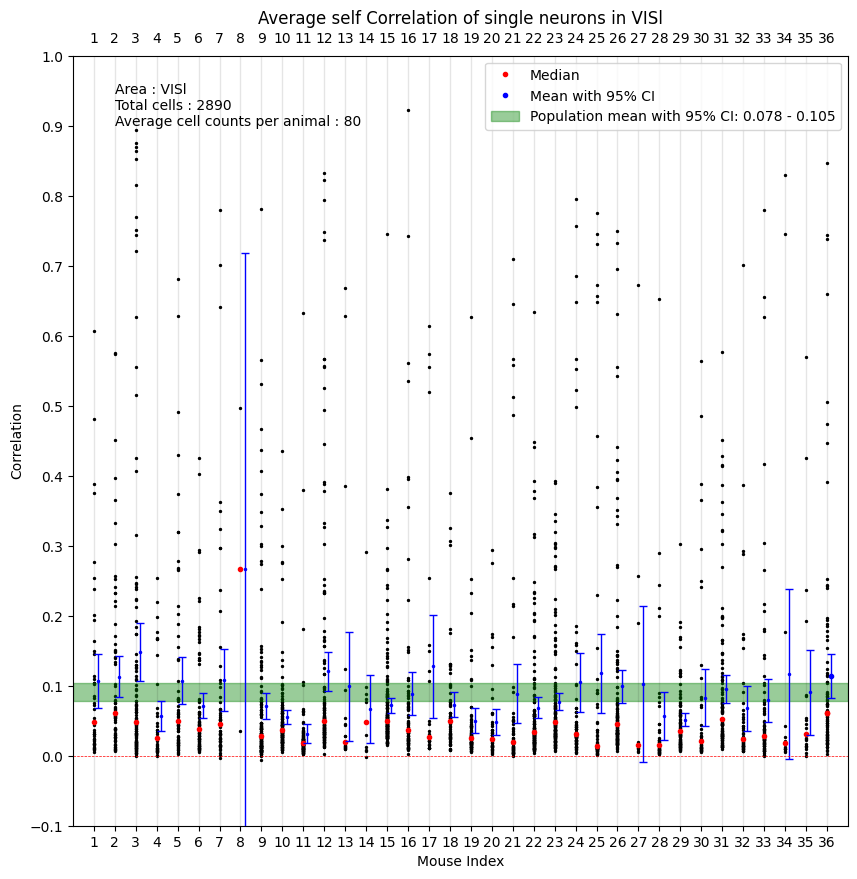

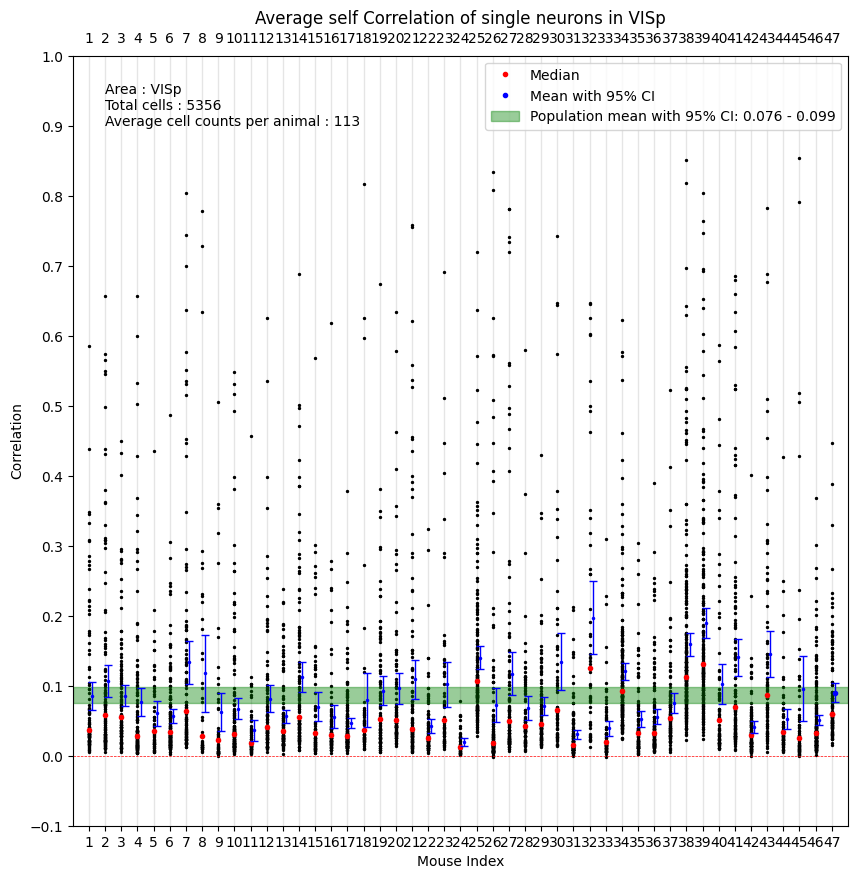

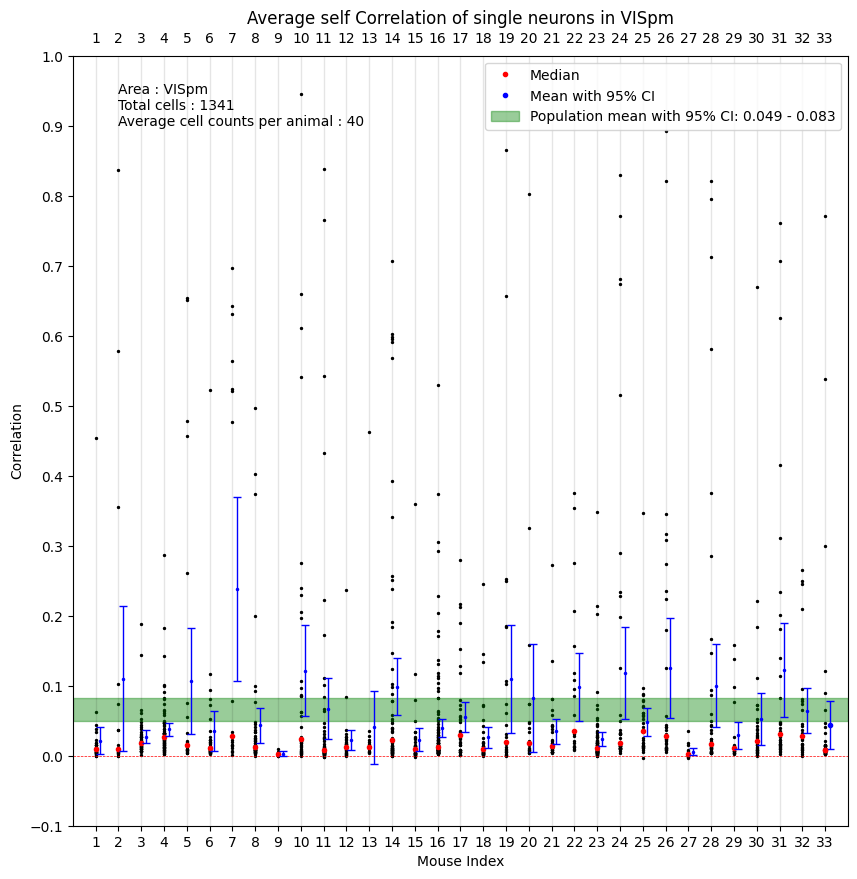

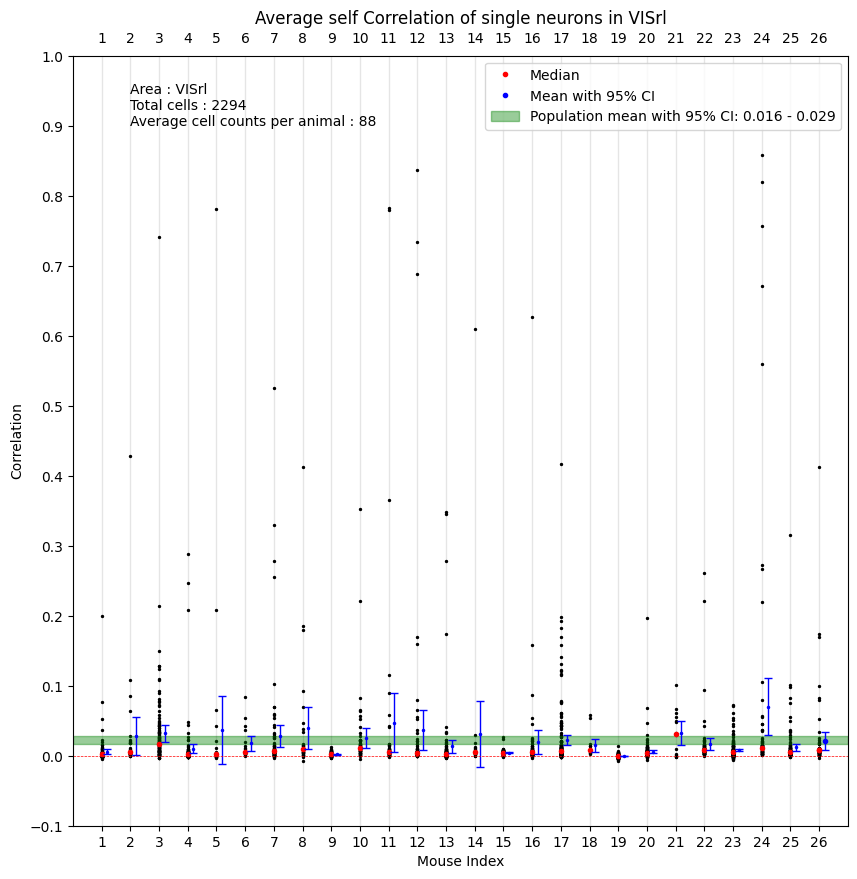

In [53]:
# mouse_index = np.random.choice(np.arange(len(mouses['VISp'])))

for area in areas:
    plt.figure(figsize=(10, 10))
    counter = 0
    means = []
    for mouse_index, mouse in enumerate(mouses[area]):
        counter = counter + mouse.dff.shape[0]

        data = np.array(mean_corr_with_error[area][mouse_index])[:, 0]

        plt.scatter(mouse_index + np.ones(len(data)), data, s = 2, color = 'k')

        plt.vlines(x = 1+ mouse_index, ymin=-0.1, ymax=1, linestyles='-', color = 'k', linewidth = 1, alpha=0.1)
        
        means.append(np.mean(data))
        
        plt.plot(1+ mouse_index, np.median(data), 'r.')
        plt.errorbar(1.2+ mouse_index, np.mean(data), yerr=1.96*np.std(data, ddof=1)/np.sqrt(len(data)), color='b', marker = '.', capsize=3, linewidth = 1, markersize=3)
        if mouse_index == len(mouses[area])-1:
            plt.plot(1+ mouse_index , np.median(data), 'r.', label='Median')
            plt.plot(1.2+ mouse_index , np.mean(data), 'b.', label='Mean with 95% CI')
    
    
    mean, err = np.mean(means), 1.96*np.std(means, ddof=1)/np.sqrt(len(means))
    params = dict(color='g', alpha=0.4, label= 'Population mean with 95% CI: ' + str(np.round(mean-err,3)) + ' - ' + str(np.round(mean+err,3)))
    plt.fill_between(x = np.arange(0, len(mouses[area])+2), y1 = mean-err, y2= mean+err, **params)
    
    plt.hlines(y = 0, xmin = 0, xmax=len(mouses[area])+1, color='r', linestyle = '--', linewidth = 0.5)
    plt.ylim([-0.1, 1])
    plt.yticks(np.arange(-0.1, 1.05, 0.1))
    plt.xlim([0, len(mouses[area])+1])
    plt.xticks(np.arange(len(mouses[area]))+1)
    plt.tick_params(axis='x', labeltop = True)
    plt.xlabel('Mouse Index')
    plt.title('Average self Correlation of single neurons in ' + area)
    plt.ylabel('Correlation')
    plt.legend(loc = 'upper right')
    text = 'Area : ' +  area + '\nTotal cells : ' + str(counter) + '\nAverage cell counts per animal : ' + str(int(counter/len(mouses[area])))
    plt.text(2, 0.9, text)
    plt.savefig('Neuronal_Self_Correlation_statistics//'+area+'.pdf')
    plt.show()
    plt.close()